# Plagiarism Detection and Essay Similarity Measurement

Welcome to the first tutorial in a series of hands-on tutorials on using the **string2string** library. 
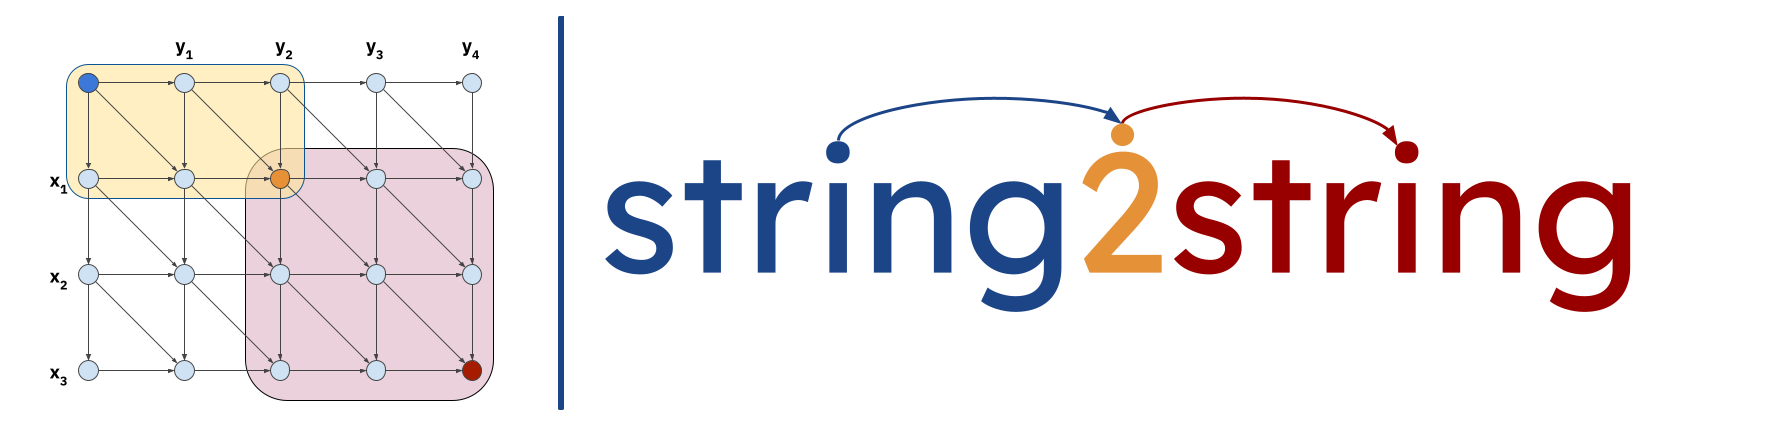

In this tutorial, we will guide you on how to use the **string2string** library for detecting plagiarism in documents. In particular, we will demonstrate how various natural-language processing  (NLP) techniques can be utilized to analyze a synthetic corpus of English-language essays that has been specifically generated for this exercise (using OpenAI's ChatGPT and Curie models). Our primary focus will be on measuring the degree of both semantic and lexical similarity between each document within the corpus using different methods, such as longest common substring and cosine similarity. Through this tutorial, we aim to provide you a comprehensive understanding of how NLP techniques can be effectively employed for plagiarism detection in documents.

Without any further ado, let's get started!

## Getting Started

First and foremost, let's use `pip install` to install the string2string library.

In [1]:
%%capture
!pip install string2string
!pip install scikit-learn
!pip install networkx

We also need to import necessary libraries and dependencies.

In [2]:
# For data processing
import numpy as np
import pandas as pd
from collections import Counter

# To compute longest common subsequence, longest common substring, and cosine similarity
from string2string.alignment import LongestCommonSubsequence, LongestCommonSubstring
from string2string.similarity import CosineSimilarity

# To perform semantic search via Faiss
from string2string.search import FaissSearch

# To load HUPD
from datasets import load_dataset

# To perform dimensionality reduction
from sklearn.manifold import TSNE

# For visualization purposes (we will use both matplotlib and plotly)
%matplotlib inline
import matplotlib.pyplot as plt
from string2string.misc.plotting_functions import plot_corpus_embeds_with_plotly

# A few additional imports
from tqdm import tqdm

/Users/machine/opt/anaconda3/envs/string2string/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the Plagiarism Detection Corpus
We will be using the small subset of the Plagiarism Detection Corpus (PDC).
* This particular subset consists of 400 essays written by two of OpenAI's language models, namely ChatGPT and Curie.
* Each essay within this subset is written in response to a specific prompt, and all prompts are related to either Jane Austen or William Shakespeare's works.

In [3]:
# Get the PDC dataset from data/Plagiarism_Detection_Corpus.csv
df = pd.read_csv('data/Plagiarism_Detection_Corpus.csv')

In [4]:
# Print the first 5 rows of the dataset
df.head()

,Title,Text,Topic,Author,Length
0,"Social Class and Marriage in ""Pride and Prejud...","Title: Social Class and Marriage in ""Pride and...",Jane Austen,ChatGPT (GPT-3.5 Turbo),574
1,The Role of Women in 18th Century England as D...,Title: The Role of Women in 18th Century Engla...,Jane Austen,ChatGPT (GPT-3.5 Turbo),520
2,The Theme of Wealth and Its Impact on Relation...,Title: The Theme of Wealth and Its Impact on R...,Jane Austen,ChatGPT (GPT-3.5 Turbo),506
3,"The Use of Satire in ""Northanger Abbey""","Title: The Use of Satire in ""Northanger Abbey""...",Jane Austen,ChatGPT (GPT-3.5 Turbo),607
4,"The Theme of Love and Self-Discovery in ""Persu...",Title: The Theme of Love and Self-Discovery in...,Jane Austen,ChatGPT (GPT-3.5 Turbo),540


In [5]:
# Initialize the similarity classes
lcsubseq = LongestCommonSubsequence()
lcsubstr = LongestCommonSubstring()

In [6]:
# Initialize a tokenizer (we will use the default tokenizer)
from string2string.misc.default_tokenizer import Tokenizer
tokenizer = Tokenizer(word_delimiter=' ')

This is not an efficient way to compute the similarity between all the essays, as we have to iterate over the entire dataset.
* We can, however, use parallel processing to speed up the entire computation. Let us see how we can do that! 

In [8]:
# As before, we are only interested in the upper triangular matrix
lcsubstr_matrix = np.zeros((len(df), len(df)))
lcsubseq_matrix = np.zeros((len(df), len(df)))

# Let us get all the essay pairs in the upper triangular matrix
essay_pairs = []
for i in range(len(df)):
    essay1 = tokenizer.tokenize(df.iloc[i]['Text'])
    for j in range(i + 1, len(df)):
        essay2 = tokenizer.tokenize(df.iloc[j]['Text'])
        essay_pairs.append((essay1, essay2))

## Measuring Lexical Similarity Between Essays

In [9]:
# Compute the similarity values for all the essay pairs
lcsubstr_results = lcsubstr.compute_multiple_pairs(essay_pairs, num_workers=8, method='joblib')
lcsubseq_results = lcsubseq.compute_multiple_pairs(essay_pairs, num_workers=8, method='joblib')

100%|██████████| 79800/79800 [32:31<00:00, 40.90it/s]  


In [10]:
# lcsubstr_results is a 1-D list of (value, alignment) tuples.. We need to convert it to a 2-D matrix efficiently and store it in lcsubstr_matrix
# We can do this by using the np.triu_indices function
indices = np.triu_indices(len(df), k=1)
lcsubstr_matrix[indices] = [x[0] for x in lcsubstr_results]
lcsubstr_matrix = lcsubstr_matrix + lcsubstr_matrix.T

# Similarly, we can do the same for lcsubseq_matrix
indices = np.triu_indices(len(df), k=1)
lcsubseq_matrix[indices] = [x[0] for x in lcsubseq_results]
lcsubseq_matrix = lcsubseq_matrix + lcsubseq_matrix.T

In [11]:
# For each essay, let us report the top 5 most similar essays, according to LCSubsequence and LCSubstring, and then add them to the dataset
top_k = 5

topk_lcsubseq_indices = np.argsort(lcsubseq_matrix, axis=1)[:, -top_k:]
topk_lcsubstr_indices = np.argsort(lcsubstr_matrix, axis=1)[:, -top_k:]

# Add the top-k indices to the dataset
df['TopK-LCSubseq-Indices'] = topk_lcsubseq_indices.tolist()
df['TopK-LCSubstr-Indices'] = topk_lcsubstr_indices.tolist()


In [12]:
df

,Title,Text,Topic,Author,Length,TopK-LCSubseq-Indices,TopK-LCSubstr-Indices
0,"Social Class and Marriage in ""Pride and Prejud...","Title: Social Class and Marriage in ""Pride and...",Jane Austen,ChatGPT (GPT-3.5 Turbo),574,"[391, 50, 305, 27, 42]","[52, 36, 19, 65, 27]"
1,The Role of Women in 18th Century England as D...,Title: The Role of Women in 18th Century Engla...,Jane Austen,ChatGPT (GPT-3.5 Turbo),520,"[305, 93, 337, 42, 51]","[0, 42, 75, 51, 301]"
2,The Theme of Wealth and Its Impact on Relation...,Title: The Theme of Wealth and Its Impact on R...,Jane Austen,ChatGPT (GPT-3.5 Turbo),506,"[213, 93, 25, 0, 22]","[272, 240, 38, 302, 52]"
3,"The Use of Satire in ""Northanger Abbey""","Title: The Use of Satire in ""Northanger Abbey""...",Jane Austen,ChatGPT (GPT-3.5 Turbo),607,"[72, 337, 93, 22, 87]","[9, 200, 53, 303, 46]"
4,"The Theme of Love and Self-Discovery in ""Persu...",Title: The Theme of Love and Self-Discovery in...,Jane Austen,ChatGPT (GPT-3.5 Turbo),540,"[12, 179, 33, 22, 25]","[287, 333, 304, 240, 54]"
...,...,...,...,...,...,...,...
395,The Representation of Friendship in Shakespear...,Title: The Representation of Friendship in Sha...,William Shakespeare,Text Curie 001,90,"[167, 117, 145, 185, 195]","[377, 385, 185, 195, 145]"
396,The Use of Repetition in Shakespeare's Plays: ...,Title: The Use of Repetition in Shakespeare's ...,William Shakespeare,Text Curie 001,335,"[389, 213, 196, 391, 146]","[204, 124, 357, 196, 146]"
397,The Significance of Names in Shakespeare's Wor...,Title: The Significance of Names in Shakespear...,William Shakespeare,Text Curie 001,272,"[370, 337, 213, 197, 391]","[179, 129, 351, 147, 197]"
398,The Representation of Masculinity in Shakespea...,Title: The Representation of Masculinity in Sh...,William Shakespeare,Text Curie 001,338,"[174, 305, 159, 187, 198]","[391, 141, 191, 148, 198]"


In [13]:
# Let us compute the rate/score of similarity for each top-k most similar essay
all_rates_lcsubseq = []
all_rates_lcsubstr = []

# Iterate over the dataset and write the rate of similarity for each topK essay
for i in range(len(df)):
    # Get the top-k most similar essays for each essay
    topk_lcsubseq = df.iloc[i]['TopK-LCSubseq-Indices']
    topk_lcsubstr = df.iloc[i]['TopK-LCSubstr-Indices']

    # Get the text of the essay i
    essay = df.iloc[i]['Text']
    length = df.iloc[i]['Length']

    # For each top-k most similar essay j, compute the similarity (LCS(i,j) / len(i)) and store it in the dataset
    rate_lcsubseq = []
    rate_lcsubstr = []
    for j in topk_lcsubseq:
        rate = lcsubseq_matrix[i, j].item() / length
        rate = round(rate, 4)
        rate_lcsubseq.append(rate)
    for j in topk_lcsubstr:
        rate = lcsubstr_matrix[i, j].item() / length
        rate = round(rate, 4)
        rate_lcsubstr.append(rate)

    all_rates_lcsubseq.append(rate_lcsubseq)
    all_rates_lcsubstr.append(rate_lcsubstr)

# Add the rates to the dataset
df['TopK-LCSubseq-Scores'] = all_rates_lcsubseq
df['TopK-LCSubstr-Scores'] = all_rates_lcsubstr

In [14]:
# Now iterate over the dataset and print all essay titles which have a Rate-LCSubse >= 0.4
for i in range(len(df)):
    rate_lcsubseq = df.iloc[i]['TopK-LCSubseq-Scores']
    rate_lcsubstr = df.iloc[i]['TopK-LCSubstr-Scores']
    
    # If the rate is greater than 0.5, print the essay title
    if any([x > 0.5 for x in rate_lcsubseq]):
        title = df.iloc[i]['Title']
        word_count = df.iloc[i]['Length']
        print(f'Essay #{i} "{title}" (word count: {word_count}) is similar to:')
        for j in range(len(rate_lcsubseq)):
            if rate_lcsubseq[j] >= .4:
                essay2_title = df.iloc[df.iloc[i]["TopK-LCSubseq-Indices"][j]]['Title']
                essay2_word_count = df.iloc[df.iloc[i]["TopK-LCSubseq-Indices"][j]]['Length']
                print(f'  - Essay #{df.iloc[i]["TopK-LCSubseq-Indices"][j]} ("{essay2_title}", WC: {essay2_word_count}, LCSubseq-Sim-Rate:{rate_lcsubseq[j]})')
                # print(f'  - Essay #{df.iloc[i]["TopK-LCSubseq"][j]} ("{essay2_title}", WC: {essay2_word_count}, LCSubseq-Sim-Rate:{rate_lcsubseq[j]})')
        print()

Essay #136 "The Significance of Ghosts and Apparitions in Shakespeare's Plays: An Analysis of Hamlet and Macbeth" (word count: 421) is similar to:
  - Essay #186 ("The Significance of Ghosts and Apparitions in Shakespeare's Plays: An Analysis of Hamlet and Macbeth", WC: 560, LCSubseq-Sim-Rate:0.5487)

Essay #334 "The Significance of the Country Estate in Jane Austen's Novels: A Comparative Study of "Mansfield Park" and "Emma"" (word count: 114) is similar to:
  - Essay #190 ("The Significance of Race in Shakespeare's Works: An Exploration of Othello and Titus Andronicus", WC: 616, LCSubseq-Sim-Rate:0.4737)
  - Essay #45 ("The Role of Money and Inheritance in Jane Austen's Novels: A Comparative Study of "Emma" and "Mansfield Park"", WC: 488, LCSubseq-Sim-Rate:0.4912)
  - Essay #39 ("The Role of Education in Jane Austen's Novels: A Comparative Study of "Pride and Prejudice" and "Emma"", WC: 558, LCSubseq-Sim-Rate:0.5)
  - Essay #84 ("The Significance of the Country Estate in Jane Austen'

## Initializing Faiss Semantic Search Tool

We will use the pre-trained Facebook OPT-125M model from Hugging Face.

In [15]:
# Let's download OPT-125M from Facebook using HuggingFace's transformers library
model_name = 'facebook/opt-125m'
faiss_search = FaissSearch(model_name_or_path = model_name)

Some weights of the model checkpoint at facebook/opt-125m were not used when initializing OPTModel: ['lm_head.weight']
- This IS expected if you are initializing OPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We have created an instance of our **Faiss Semantic Search** model, with OPT-125M as our language model. 

* We are now ready to initialize the corpus with the Plagiarism Detection dataset.

In [16]:
# Let's initialize and process the corpus
faiss_search.initialize_corpus(
    corpus=df,
    section='Text', 
    embedding_type='mean_pooling',
    batch_size=16,
)

100%|██████████| 400/400 [05:11<00:00,  1.29ex/s]


Adding FAISS index...


100%|██████████| 1/1 [00:00<00:00, 570.42it/s]


Dataset({
    features: ['Title', 'Text', 'Topic', 'Author', 'Length', 'TopK-LCSubseq-Indices', 'TopK-LCSubstr-Indices', 'TopK-LCSubseq-Scores', 'TopK-LCSubstr-Scores', 'embeddings'],
    num_rows: 400
})

In [17]:
# Let's get the embeddings, titles, and labels
embeddings = np.array(faiss_search.dataset['embeddings']).squeeze()
titles = faiss_search.dataset['Title']
topics = faiss_search.dataset['Topic']

In [18]:
# Let's print the shape of the patent_embeddings
print(embeddings.shape) # (number of essays, embedding dimension)

(400, 768)


## Dimensionality Reduction with t-SNE

The original average-token embeddings of essays are 768-dimensional. We will use t-SNE to reduce the dimensionality to 2, so that we can visualize the essay embeddings in a 2D-space.

To accomplish this, we will use the sklearn.manifold.TSNE class. 
* We will use the default parameters but set the perplexity to 25.
* Furthermore, we will set the random_state to 1729, so that we can reproduce the results.
* Finally, we wil set the verbose parameter to 1, so that we can see the progress of the algorithm.

Now, let's perform dimensionality reduction on the patent embeddings

In [19]:
# Initialize the TSNE model with the parameters we want to use for dimensionality reduction
# We will make use of the tSNE implementation from scikit-learn, with a random seed of 1729 for reproducibility purposes and a perplexity rate of 25
tsne = TSNE(n_components=2, perplexity=25, random_state=1729, verbose=1)

In [20]:
# Fit the model to the patent embeddings
tsne_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 3.347212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.924545
[t-SNE] KL divergence after 1000 iterations: 0.530900


In [21]:
tsne_embeddings.shape

(400, 2)

## Visualization of the Embeddding Space

#### Visualize the embedding space using **matplotloib**.

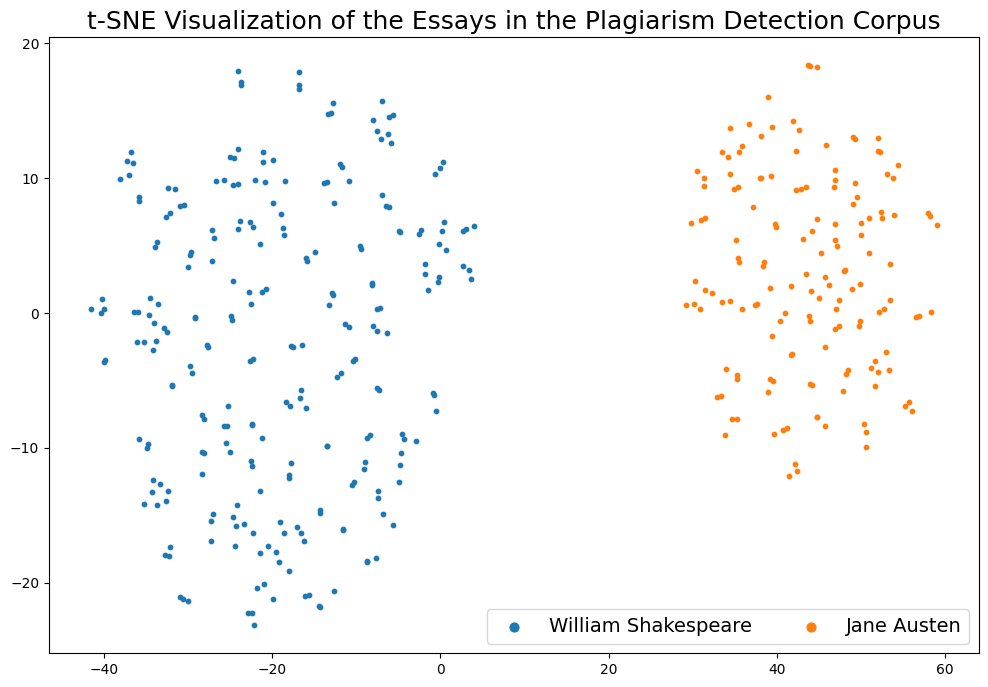

In [22]:
# Initialize the plot 
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
 

for topic in list(set(topics)):

    indices = list(df[df['Topic'] == topic].index) # [i for i, l in enumerate(topics) if l == label]
 
    # Extract the coordinates of the points of this class only
    current_tx = np.take(tsne_embeddings[:, 0], indices)
    current_ty = np.take(tsne_embeddings[:, 1], indices)
 
    # Add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, label=topic, s=10)
 
# build a legend using the labels we set previously (let's put a title as well)
ax.legend(loc='best', fontsize=14, markerscale=2, ncol=2)
 
plt.title('t-SNE Visualization of the Essays in the Plagiarism Detection Corpus', fontsize=18)
# finally, show the plot
plt.show()

We can alternatively create an interactive plot using **plotly**!

In [23]:
def prepare_plotly_data(embeddings, titles, topics):
    # Initialize the lists that will contain the tSNE coordinates, labels, titles, and hover texts (for matplotlib and plotly)
    tsne_coords = []
    tsne_labels = []
    tsne_titles = []
    tsne_hover_texts = []

    # Let's get the tSNE coordinates, labels, and titles for the most common labels
    for i, label in enumerate(topics):
        tsne_coords.append(embeddings[i])
        tsne_labels.append(label)
        tsne_titles.append(titles[i])
        tsne_hover_texts.append(f'Title: {titles[i]}')
    
    # Return the lists
    return tsne_coords, tsne_labels, tsne_titles, tsne_hover_texts

In [24]:
# Let's prepare the data for plotly
tsne_coords, tsne_labels, tsne_titles, tsne_hover_texts = prepare_plotly_data(
    tsne_embeddings, titles, topics)

We will use the plot_corpus_embeds_with_plotly function from the string2string.misc.plotting_functions module, which makes use of the scatter function from the plotly.express module specifically to visualize the embeddings of a corpus of documents

In [25]:
# Let'x initialize the plotly layout
layoot_dict={
    "template":'simple_white',
    "legend_title_text":'Topic',
    "legend_font_size":14,
    "height":600,
    "width":1200,
    "title": "t-SNE Visualization of the Essays in the Plagiarism Detection Corpus",
    "title_x":0.5,
    "xaxis_title":'Dimension 1',
    "yaxis_title":'Dimension 2'
}

In [26]:
# We are finally ready to plot the corpus embeddings with plotly! 
corpus_fig = plot_corpus_embeds_with_plotly(
    corpus_embeddings=tsne_coords,
    corpus_labels=tsne_labels,
    corpus_hover_texts=tsne_hover_texts,
    layoot_dict=layoot_dict,
    show_plot=True,
)

In [28]:
semantic_similarity_scores = []
semantic_similarity_indices = []
for query in tqdm(df['Text']):
    # Let's get the top 4 results for each query (including the query itself)
    results = faiss_search.search(query, k=6)
    # Get the indices of the most similar documents (excluding the query itself which is the first result)
    similar_texts = results['Text'][1:].values
    # Get the similarity scores of the most similar documents and round them to 4 decimal places
    similarity_scores = results['score'][1:].values
    similarity_scores = [round(score, 4) for score in similarity_scores]
    # Get the indices of the most similar documents
    similar_score_indices = [df[df['Text'] == text].index[0] for text in similar_texts]
    # Append the results to the lists
    semantic_similarity_scores.append(similarity_scores)
    semantic_similarity_indices.append(similar_score_indices)

# Let's add the results to the dataframe
df['TopK-Semantic-Similarity-Scores'] = semantic_similarity_scores
df['TopK-Semantic-Similarity-Indices'] = semantic_similarity_indices

100%|██████████| 400/400 [05:27<00:00,  1.22it/s]


#### Performing a Semantic Search Query on the Corpus
* Next, we will perform a semantic search query on the corpus. We will use another ChatGPT-generated essay on the topic of "*The Depiction of Love and Marriage in Jane Austen and William Shakespeare's Works*" as our query and find the most semantically similar essays in the corpus.
* We will then visualize the results using t-SNE.

In [31]:
# Here is the query we want to search for
query = r"""Title: The Depiction of Love and Marriage in Jane Austen and William Shakespeare's Works

Both Jane Austen and William Shakespeare present complex and nuanced depictions of love and marriage in their works, highlighting the social conventions and power dynamics that shape courtship and marital relationships. However, while Austen's novels emphasize the importance of compatibility, mutual respect, and shared values in successful marriages, Shakespeare's plays often explore the tragic consequences of love that is driven by passion and societal pressure rather than genuine affection.

Jane Austen's novels, such as Pride and Prejudice and Sense and Sensibility, are renowned for their sharp critique of the social norms and gender roles that govern courtship and marriage in the Regency era. Austen challenges the prevailing notion that marriage is primarily a means of securing financial stability and social status, portraying characters who seek genuine emotional and intellectual connections with their partners. For instance, in Pride and Prejudice, Elizabeth Bennet resists her mother's pressure to marry a wealthy and titled man and instead falls in love with Mr. Darcy, a man whom she initially dislikes due to his pride and aloofness. Their relationship evolves through a series of misunderstandings and self-reflection, leading to a mutual recognition of their faults and virtues. Similarly, in Sense and Sensibility, the Dashwood sisters navigate the challenges of romantic attachment and social expectations, ultimately finding happiness with men who share their values and interests.

In contrast, William Shakespeare's plays, such as Romeo and Juliet and Othello, often depict love and marriage as tragic and fraught with conflict. Shakespeare portrays characters who are driven by intense emotions and societal pressures, leading them to make rash decisions that result in ruin and despair. For example, in Romeo and Juliet, the young lovers defy their feuding families and elope, but their passion is ultimately their downfall, as their families' enmity leads to a series of tragic events that culminate in their deaths. Similarly, in Othello, the titular character's jealousy and mistrust of his wife, Desdemona, ultimately leads to her murder, highlighting the destructive power of toxic masculinity and insecurity.

Furthermore, while Austen's novels emphasize the importance of compatibility and shared values in successful marriages, Shakespeare's plays often depict marriages that are fraught with power imbalances and emotional distance. For instance, in The Taming of the Shrew, Petruchio marries Katherine, a headstrong and independent woman, and seeks to "tame" her into submission through verbal and physical abuse. Although the play is often interpreted as a satire of gender norms, it nevertheless reinforces the patriarchal notion that women must be subordinated to men in marriage. Similarly, in Macbeth, the titular character's ambition and thirst for power lead him to murder his king and estrange himself from his wife, Lady Macbeth, who ultimately succumbs to guilt and madness.

In conclusion, Jane Austen and William Shakespeare offer contrasting depictions of love and marriage in their works, reflecting the social and cultural norms of their respective eras. Austen's novels emphasize the importance of emotional and intellectual compatibility in successful marriages, challenging the notion that marriage is primarily a financial transaction. In contrast, Shakespeare's plays often explore the tragic consequences of love that is driven by passion and societal pressure rather than genuine affection. While both Austen and Shakespeare offer complex and nuanced depictions of love and marriage, their works ultimately serve as a commentary on the enduring human desire for connection and companionship.

Word Count: 797
"""

# Let's get the top 10 results
results = faiss_search.search(query, k=15)

In [32]:
results

,Title,Text,Topic,Author,Length,TopK-LCSubseq-Indices,TopK-LCSubstr-Indices,TopK-LCSubseq-Scores,TopK-LCSubstr-Scores,embeddings,score
0,The Representation of Love and Marriage in Jan...,Title: The Representation of Love and Marriage...,Jane Austen,ChatGPT (GPT-3.5 Turbo),501,"[42, 4, 162, 33, 25]","[176, 178, 160, 333, 33]","[0.2076, 0.2076, 0.2096, 0.2116, 0.2275]","[0.016, 0.016, 0.016, 0.02, 0.0259]","[0.12582623958587646, 1.0541960000991821, -1.1...",34.530983
1,The Concept of Courtship in Jane Austen's Nove...,Title: The Concept of Courtship in Jane Austen...,Jane Austen,ChatGPT (GPT-3.5 Turbo),554,"[90, 0, 45, 39, 41]","[349, 99, 39, 90, 340]","[0.2238, 0.2238, 0.2274, 0.2347, 0.2365]","[0.0199, 0.0199, 0.0235, 0.0289, 0.0289]","[0.14683929085731506, 1.157120704650879, -0.89...",35.640686
2,The Concept of Courtship in Jane Austen's Nove...,Title: The Concept of Courtship in Jane Austen...,Jane Austen,ChatGPT (GPT-3.5 Turbo),531,"[0, 5, 39, 305, 40]","[49, 349, 99, 40, 340]","[0.2128, 0.2147, 0.2147, 0.2203, 0.2335]","[0.0207, 0.0207, 0.0207, 0.0301, 0.0301]","[0.24101261794567108, 0.742192268371582, -0.87...",37.584045
3,"The Portrayal of Marriage and Family Life in ""...",Title: The Portrayal of Marriage and Family Li...,Jane Austen,ChatGPT (GPT-3.5 Turbo),395,"[47, 5, 22, 32, 12]","[269, 48, 22, 312, 12]","[0.2481, 0.2532, 0.2532, 0.2582, 0.3114]","[0.0152, 0.0177, 0.0177, 0.0304, 0.0456]","[0.19256295263767242, 1.591489315032959, -1.03...",38.129040
4,The Representation of Love and Marriage in Jan...,Title: The Representation of Love and Marriage...,Jane Austen,ChatGPT (GPT-3.5 Turbo),396,"[0, 83, 22, 25, 4]","[46, 0, 25, 333, 83]","[0.2525, 0.2677, 0.2677, 0.2854, 0.2904]","[0.0202, 0.0202, 0.0253, 0.0253, 0.0328]","[0.02844689041376114, 1.0151571035385132, -0.9...",43.324501
5,Love and Class Struggle in Jane Austen's “Sens...,Title: Love and Class Struggle in Jane Austen'...,Jane Austen,ChatGPT (GPT-3.5 Turbo),533,"[213, 337, 22, 0, 25]","[42, 38, 325, 1, 25]","[0.2045, 0.2064, 0.2101, 0.2345, 0.2402]","[0.015, 0.0169, 0.0188, 0.0188, 0.0244]","[0.24964095652103424, 1.5403356552124023, -1.2...",44.673409
6,The Significance of Money and Property in Jane...,Title: The Significance of Money and Property ...,Jane Austen,ChatGPT (GPT-3.5 Turbo),455,"[70, 12, 41, 20, 29]","[20, 97, 37, 329, 29]","[0.2088, 0.2132, 0.2154, 0.2176, 0.2352]","[0.0132, 0.0132, 0.0176, 0.044, 0.044]","[0.2702871859073639, 1.0940738916397095, -1.14...",46.135811
7,"Social Class and Marriage in ""Pride and Prejud...","Title: Social Class and Marriage in ""Pride and...",Jane Austen,ChatGPT (GPT-3.5 Turbo),559,"[213, 32, 22, 305, 0]","[299, 84, 41, 300, 0]","[0.2075, 0.2182, 0.22, 0.2218, 0.2326]","[0.0107, 0.0125, 0.0125, 0.0143, 0.0143]","[0.04900261014699936, 1.613915205001831, -1.06...",46.387897
8,Jane Austen's Representation of Marriage as a ...,Title: Jane Austen's Representation of Marriag...,Jane Austen,ChatGPT (GPT-3.5 Turbo),575,"[1, 20, 22, 51, 42]","[45, 99, 20, 342, 42]","[0.1826, 0.1843, 0.1843, 0.1843, 0.2104]","[0.0104, 0.0104, 0.0104, 0.0226, 0.0243]","[0.2778869867324829, 2.0291404724121094, -1.06...",46.455025
9,"The Portrayal of Marriage and Family Life in ""...",Title: The Portrayal of Marriage and Family Li...,Jane Austen,ChatGPT (GPT-3.5 Turbo),600,"[47, 5, 32, 305, 337]","[93, 17, 312, 76, 62]","[0.2083, 0.2083, 0.2233, 0.225, 0.225]","[0.0133, 0.0183, 0.02, 0.02, 0.03]","[-0.015704311430454254, 0.8836566209793091, -1...",49.198845


Let's print the most similar essays (and their word counts).

In [33]:

print(f'The query essay is similar to the following essays in the corpus:')
# Go over the results and print the title and word count of each essay
for index, row in results.iterrows():
    title = row['Title']
    word_count = row['Length']
    score = row['score']
    print(f'Title: {title} - Word Count: {word_count}')


The query essay is similar to the following essays in the corpus:
Title: The Representation of Love and Marriage in Jane Austen's "Persuasion" - Word Count: 501
Title: The Concept of Courtship in Jane Austen's Novels: A Study of "Pride and Prejudice" and "Emma" - Word Count: 554
Title: The Concept of Courtship in Jane Austen's Novels: A Study of "Pride and Prejudice" and "Emma" - Word Count: 531
Title: The Portrayal of Marriage and Family Life in "Mansfield Park" and "Persuasion" - Word Count: 395
Title: The Representation of Love and Marriage in Jane Austen's "Persuasion" - Word Count: 396
Title: Love and Class Struggle in Jane Austen's “Sense and Sensibility.” - Word Count: 533
Title: The Significance of Money and Property in Jane Austen’s Novels: A Study of “Pride and Prejudice” and “Sense and Sensibility.” - Word Count: 455
Title: Social Class and Marriage in "Pride and Prejudice" - Word Count: 559
Title: Jane Austen's Representation of Marriage as a Social Contract in "Sense and S

In [34]:
# Get the embeddings of the query and concatenate them with the patent embeddings
query_embeddings = faiss_search.get_embeddings([query], embedding_type="mean_pooling").detach().cpu().numpy()
concatenated_data = np.concatenate((embeddings, query_embeddings), axis=0)

# Let's fit the tSNE model to the concatenated data
tsne_all_embeddings = tsne.fit_transform(concatenated_data) 

# Our query embeddings are the last 1 in the concatenated data
tsne_query_embeddings = tsne_all_embeddings[-1]

# Get the tSNE coordinates, labels, titles, and hover texts for the most common labels
tsne_coords, tsne_labels, tsne_titles, tsne_hover_texts = prepare_plotly_data(
    tsne_all_embeddings, titles, topics)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 401 samples in 0.000s...
[t-SNE] Computed neighbors for 401 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 401 / 401
[t-SNE] Mean sigma: 3.341888
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.066166
[t-SNE] KL divergence after 1000 iterations: 0.531256


#### Visualization of the Search Results

Let us plot both the corpus embeddings and the query embedding in the same plot!

In [35]:
new_fig = plot_corpus_embeds_with_plotly(
    corpus_embeddings=tsne_coords,
    corpus_labels=tsne_labels,
    corpus_hover_texts=tsne_hover_texts,
    layoot_dict=layoot_dict,
    query_embeddings=[tsne_query_embeddings],
    query_labels=['Query'],
    query_hover_texts=['Query Patent'],
    query_modes='markers',
    query_marker_dict={
        "color": "black",
        "size": 24,
        "line": {
            "color": "white",
            "width": 2,
        },  
        "symbol": "diamond",
    },
    show_plot=True,
)

In [36]:
edge_list = []
edge_weight_dict = {} # for networkx (e.g., {0: {1: {"weight": 1}}}  # single edge (0,1))
for index, row in df.iterrows():
    # for each essay, add an edge from index to elements in the TopK-Semantic-Similarity-Indices column
    for index2 in row['TopK-Semantic-Similarity-Indices'][:3]:
        edge_list.append((index, index2))
        # add the weight of the edge, which is stored in the TopK-Semantic-Similarity-Scores column 
        edge_weight_dict[index] = {index2: {"weight": row['TopK-Semantic-Similarity-Scores'][row['TopK-Semantic-Similarity-Indices'].index(index2)]}}

In [38]:
df

,Title,Text,Topic,Author,Length,TopK-LCSubseq-Indices,TopK-LCSubstr-Indices,TopK-LCSubseq-Scores,TopK-LCSubstr-Scores,TopK-Semantic-Similarity-Scores,TopK-Semantic-Similarity-Indices
0,"Social Class and Marriage in ""Pride and Prejud...","Title: Social Class and Marriage in ""Pride and...",Jane Austen,ChatGPT (GPT-3.5 Turbo),574,"[391, 50, 305, 27, 42]","[52, 36, 19, 65, 27]","[0.223, 0.2265, 0.2352, 0.2352, 0.2387]","[0.0157, 0.0157, 0.0157, 0.0174, 0.0366]","[22.6066, 27.8086, 30.2542, 32.6548, 34.0562]","[50, 40, 75, 42, 16]"
1,The Role of Women in 18th Century England as D...,Title: The Role of Women in 18th Century Engla...,Jane Austen,ChatGPT (GPT-3.5 Turbo),520,"[305, 93, 337, 42, 51]","[0, 42, 75, 51, 301]","[0.2231, 0.225, 0.2288, 0.2423, 0.2827]","[0.0154, 0.0173, 0.0192, 0.0269, 0.0269]","[13.2546, 34.5886, 35.948, 35.953, 38.5655]","[51, 301, 92, 88, 16]"
2,The Theme of Wealth and Its Impact on Relation...,Title: The Theme of Wealth and Its Impact on R...,Jane Austen,ChatGPT (GPT-3.5 Turbo),506,"[213, 93, 25, 0, 22]","[272, 240, 38, 302, 52]","[0.2095, 0.2095, 0.2115, 0.2115, 0.2154]","[0.0138, 0.0138, 0.0158, 0.0217, 0.0217]","[24.3124, 38.068, 38.6159, 43.659, 47.6103]","[52, 79, 50, 95, 75]"
3,"The Use of Satire in ""Northanger Abbey""","Title: The Use of Satire in ""Northanger Abbey""...",Jane Austen,ChatGPT (GPT-3.5 Turbo),607,"[72, 337, 93, 22, 87]","[9, 200, 53, 303, 46]","[0.196, 0.1977, 0.1993, 0.2092, 0.2092]","[0.0115, 0.0115, 0.0115, 0.0115, 0.0115]","[27.5464, 30.9838, 33.8692, 44.0619, 44.1406]","[53, 76, 9, 96, 26]"
4,"The Theme of Love and Self-Discovery in ""Persu...",Title: The Theme of Love and Self-Discovery in...,Jane Austen,ChatGPT (GPT-3.5 Turbo),540,"[12, 179, 33, 22, 25]","[287, 333, 304, 240, 54]","[0.2074, 0.2074, 0.213, 0.2278, 0.2389]","[0.0148, 0.0148, 0.0148, 0.0148, 0.0185]","[28.6085, 31.4169, 33.6889, 35.6571, 36.9277]","[54, 33, 304, 83, 98]"
...,...,...,...,...,...,...,...,...,...,...,...
395,The Representation of Friendship in Shakespear...,Title: The Representation of Friendship in Sha...,William Shakespeare,Text Curie 001,90,"[167, 117, 145, 185, 195]","[377, 385, 185, 195, 145]","[0.4778, 0.4778, 0.4889, 0.5, 0.6111]","[0.0778, 0.0778, 0.0778, 0.2111, 0.2111]","[67.8342, 78.4333, 79.201, 83.0268, 84.0943]","[372, 195, 364, 378, 145]"
396,The Use of Repetition in Shakespeare's Plays: ...,Title: The Use of Repetition in Shakespeare's ...,William Shakespeare,Text Curie 001,335,"[389, 213, 196, 391, 146]","[204, 124, 357, 196, 146]","[0.3075, 0.3194, 0.3224, 0.3313, 0.3313]","[0.0209, 0.0209, 0.0269, 0.0478, 0.0478]","[29.8214, 35.5274, 58.5119, 60.5157, 62.0831]","[196, 146, 171, 352, 152]"
397,The Significance of Names in Shakespeare's Wor...,Title: The Significance of Names in Shakespear...,William Shakespeare,Text Curie 001,272,"[370, 337, 213, 197, 391]","[179, 129, 351, 147, 197]","[0.2904, 0.2941, 0.2978, 0.3199, 0.3235]","[0.0257, 0.0257, 0.0294, 0.0551, 0.0588]","[46.3205, 59.3486, 72.2089, 75.2083, 79.369]","[147, 197, 390, 166, 116]"
398,The Representation of Masculinity in Shakespea...,Title: The Representation of Masculinity in Sh...,William Shakespeare,Text Curie 001,338,"[174, 305, 159, 187, 198]","[391, 141, 191, 148, 198]","[0.3018, 0.3047, 0.3077, 0.3166, 0.3195]","[0.0207, 0.0207, 0.0207, 0.0533, 0.0533]","[29.7092, 31.8584, 51.5532, 51.7136, 53.9744]","[198, 148, 166, 169, 258]"


## Network Graph Visualization of Similar Essays

#### Visualization of the Semantically Similar Essays in the Corpus as a Network Graph

In [39]:
# Let's important specific modules that we will use for plotting a network graph with plotly
import plotly.graph_objects as go 
import networkx as nx

In [40]:
# Let's create a graph from the edge list that we created earlier
G = nx.from_dict_of_dicts(edge_weight_dict)
pos = nx.spring_layout(G, weight='weight', k=0.5, iterations=50, scale=1, center=None, dim=2, seed=42)
nx.set_node_attributes(G, pos, 'pos')


Let's get all the specific information that we need to plot the graph.
* **N.B.** Please feel free to skip the following part.

In [41]:
# Edge positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    # Alas, the following doesn't work: line=dict(width=[G[u][v]['weight'] for u,v in G.edges()], color='#888'),
    # So we have to use the following standard line marker instead:
    line=dict(width=0.5, color='#D3D3D3'), 
    hoverinfo='none',
    mode='lines',
    )

# Node positions
node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

# Node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Portland',
        reversescale=True,
        color=[],
        size=[G.degree(node) * 5 for node in G.nodes()],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2,
        )
    )

# Node adjacencies and text
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    # Essay / Title / Word Count
    node_text.append(f'Essay #{adjacencies[0]}: <br>{df.loc[adjacencies[0], "Title"]}<br> Word Count: {df.loc[adjacencies[0], "Length"]}')

# Node trace color and text
node_trace.marker.color = node_adjacencies
node_trace.text = node_text

Let us plot the semantic similarity graph with **plotly**!

In [42]:
# We are finally ready to plot the graph
fig = go.Figure(
    data=[edge_trace, node_trace],
   layout=go.Layout(
      title='<b>Semantic Similarity Graph of Essays</b><br>(for each essay, the most similar three essays are connected by an edge)',
      title_x=0.5,
      titlefont_size=18,
      hovermode='closest',
      margin=dict(b=20,l=5,r=5,t=40),
      xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
      yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
      width=1200,
      height=600,
      template='plotly_white',
      ),
      )
fig.show()

#### Observations:

* The graph reveals that several essays, such as Essay #118, Essay #301, and Essay #236 (highlighted in darker shades of blue), exhibit numerous connections with other essays. This implies that these essays possess a significant degree of semantic similarity with a wide range of other essays. 

* If these essays were actual academic papers or school essays, for instance, it would be worthwhile to investigate them further to determine whether they are genuinely comparable and examine whether there are any indications of plagiarism.

>  With this example, we have reached the end of this tutorial. We hope that you have found it useful. If you have any questions or suggestions, please feel free to contact us.

##### $\square$ Q.E.D.